<a href="https://colab.research.google.com/github/farhan1503001/Generative-Deep-Learning-With-Tensorflow/blob/main/DCGAN/DCGAN_using_Fashion_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN Implementation
**Here we will employ DCGAN using MNIST Dataset**

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
#Function for visualizing created fake images
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

**Downloading and preparing the dataset**

In [3]:
#Now first downloading image dataset
(x_train,_),_=keras.datasets.fashion_mnist.load_data()
#Now preprocessing data
x_train=x_train.astype(np.float32)/255.0
#Now seeing the shape of the dataset
print("initial shape: ",x_train.shape)
#resize the data and also rescale
x_train=x_train.reshape(-1,28,28,1)*2.0-1
print("Final shape: ",x_train.shape)
#Now creating our data loaders
Batch_size=128
dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset=dataset.batch(Batch_size,drop_remainder=True).prefetch(1)

4431872/4422102 [==============================] - 0s 0us/step
initial shape:  (60000, 28, 28)
Final shape:  (60000, 28, 28, 1)


# Model Creation
**Generator Section here is created by Conv2DTranspose**

In [4]:
#Now writing generator section
dimension_size=32

generator=keras.models.Sequential(
    [
     keras.layers.Dense(7*7*128,input_shape=[dimension_size]),
     keras.layers.Reshape([7,7,128]),
     #Now batch norm
     keras.layers.BatchNormalization(),
     #Now upsampling to create 14,14
     keras.layers.Conv2DTranspose(filters=64,kernel_size=5,strides=2,padding='same',activation='selu'),
     keras.layers.BatchNormalization(),
     keras.layers.Conv2DTranspose(filters=1,kernel_size=5,strides=2,padding='same',activation='tanh')
    ]
)

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              206976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

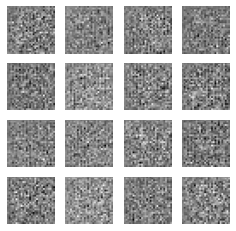

In [5]:
#Now noise testing
test_noise=tf.random.normal([16,dimension_size])
fake=generator(test_noise)
plot_results(fake,n_cols=4)

**Discriminator created using Conv2d layer**

In [6]:
discriminator=keras.models.Sequential(
    [
     keras.layers.Conv2D(filters=64,kernel_size=5,strides=2,padding='same',
                         activation=keras.layers.LeakyReLU(0.2),
                         input_shape=[28,28,1]
                         ),
     keras.layers.Dropout(0.2),
     keras.layers.Conv2D(filters=128,kernel_size=5,strides=2,padding='same',
                         activation=keras.layers.LeakyReLU(0.2)
                         ),
     keras.layers.Dropout(0.4),
     keras.layers.Flatten(),
     keras.layers.Dense(1,activation='sigmoid')
    ]
)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-tr

In [7]:
gan = keras.models.Sequential([generator, discriminator])

In [8]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Training Section

In [9]:
def train_gan(gan, dataset, random_normal_dimensions, epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1,epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images, 16)                     
        plt.show()      

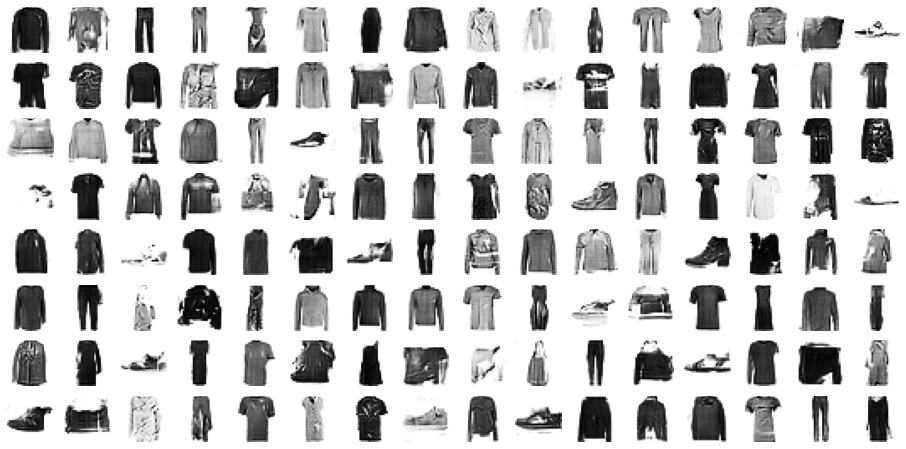

In [10]:
train_gan(gan, dataset,random_normal_dimensions=dimension_size,epochs=100)